In [1]:
import pandas as pd 
import numpy as np 
import pingouin as pg 
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import mahalanobis
from sklearn.preprocessing import MinMaxScaler

In [2]:
def get_residuals(global_WM, scan_age):
    
    from pingouin import linear_regression
    
    lm = linear_regression( X= scan_age, y = global_WM)
    return lm.residuals_

In [3]:
## to fix the ordering for plots 
pair_names = [
    'M1-Brainstem', 'S1-Brainstem','Paracentral-Brainstem',
    'M1-Caud', 'S1-Caud','Paracentral-Caud',
    'M1-Lenti', 'S1-Lenti','Paracentral-Lenti', 
    'M1-Thalfus', 'S1-Thalfus','Paracentral-Thalfus', 
    'M1L-M1R', 'S1L-S1R',
    'S1-M1' ]

In [4]:
# read in the metric files saved as csv
controls = pd.read_csv('../../DerivedData/extracted_diffusion_metrics_control_group_mergedLR.csv', index_col=0)
preterms = pd.read_csv('../../DerivedData/extracted_diffusion_metrics_preterm_group_mergedLR.csv', index_col=0)

### create pairing - as there is fewer preterms, use their IDs to find matches with controls 
matched = pd.read_csv('../../DerivedData/subject_matching.csv', index_col=0)
matched = matched[matched['preterm_ID'].isin(preterms['subject_id'].values)]

#get matched controls
controls = controls[controls.subject_id.isin(matched.matched_ID_with_outcome.values)]

preterm_ids = preterms.subject_id.values
control_ids = controls.subject_id.values

### concatenate the two 
df = pd.concat([preterms, controls])

# Clinical variables 
clinic = pd.read_csv('../../DerivedData/Global.csv', sep=';')
to_keep = ['ParticipantID', 'FetalGrowthRestriction', 'ParenteralNutrition>21d', 'Pregnancy-size', 
          'Sex', 'Gabirth', 'PMA-MRI']
clinic = clinic[to_keep]
clinic.rename( columns ={
                'ParticipantID' : 'subject_id',
                'ParenteralNutrition>21d' : 'ParenteralNutrition',
                'Pregnancy-size' : 'PregnancySize', 
                'Gabirth' : 'birth_age',
                'PMA-MRI' : 'scan_age'
                }, inplace=True)


df = pd.merge(df, clinic, how="outer", on=["subject_id"])

for col in ['birth_age', 'scan_age']:
        df[col] = df[col].astype(str)
        df[col] = df[col].apply(lambda x: x.replace(',','.'))
        df[col] = df[col].astype(np.float16)

### categorize what needs to be categorized

for col in ['ParenteralNutrition','PregnancySize', 'FetalGrowthRestriction', 'Sex']:
    df[col] = df[col].astype('category')
    df[col] = df[col].cat.codes

###
# compute residual WM 
## need mean WM ~ PMA-MRI

ex_WM = pd.read_csv('../../DerivedData/extreme_pairs_mean_diffusion_metrics_over_WM.csv', index_col=0)
mod_WM = pd.read_csv('../../DerivedData/moderate_pairs_mean_diffusion_metrics_over_WM.csv', index_col=0)

WM = pd.concat([ex_WM, mod_WM])
WM.rename(columns={'matched_ID' : 'control_ID'}, inplace=True)

preterm_cols = [col for col in WM.columns if 'preterm' in col]
preterm_cols = [col for col in preterm_cols if 'post' not in col]
matched_cols = [col for col in WM.columns if 'control' in col]
matched_cols = [col for col in matched_cols  if 'post' not in col]

pt = WM[preterm_cols].copy()
mt = WM[matched_cols].copy()

pt = pt.set_axis([col.split('_')[1] for col in preterm_cols] , axis=1, inplace=False)
mt = mt.set_axis([col.split('_')[1] for col in matched_cols] , axis=1, inplace=False)

pt.reset_index(drop=True, inplace=True)
mt.reset_index(drop=True, inplace=True)

#del WM

new_WM = pt.copy()
new_WM = new_WM.append(mt.copy())

new_WM = new_WM.set_axis(['meanWM_' + col for col in pt.columns] , axis=1, inplace=False)
new_WM.rename(columns={'meanWM_ID': 'subject_id'}, inplace =True)

df = pd.merge(df, new_WM, how="outer", on=["subject_id"])

for metric in ['AD', 'RD', 'FA', 'MD', 'NDI', 'ODI']:

    df['residual_'+metric] = get_residuals(global_WM = np.float32(df['meanWM_' + metric].values), 
                                           scan_age = np.float32(df['scan_age'].values))

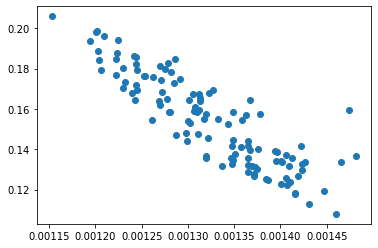

In [5]:
plt.scatter(df['meanWM_'+'MD'], df['meanWM_'+'NDI'])
test = pg.linear_regression(df['meanWM_'+'MD'], df['meanWM_'+'NDI'])
plt.show()


In [6]:
test

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,0.513209,0.018489,27.757290,4.707671e-53,0.76521,0.763186,0.476589,0.549829
1,meanWM_MD,-271.237415,13.949861,-19.443736,2.661714e-38,0.76521,0.763186,-298.866872,-243.607957


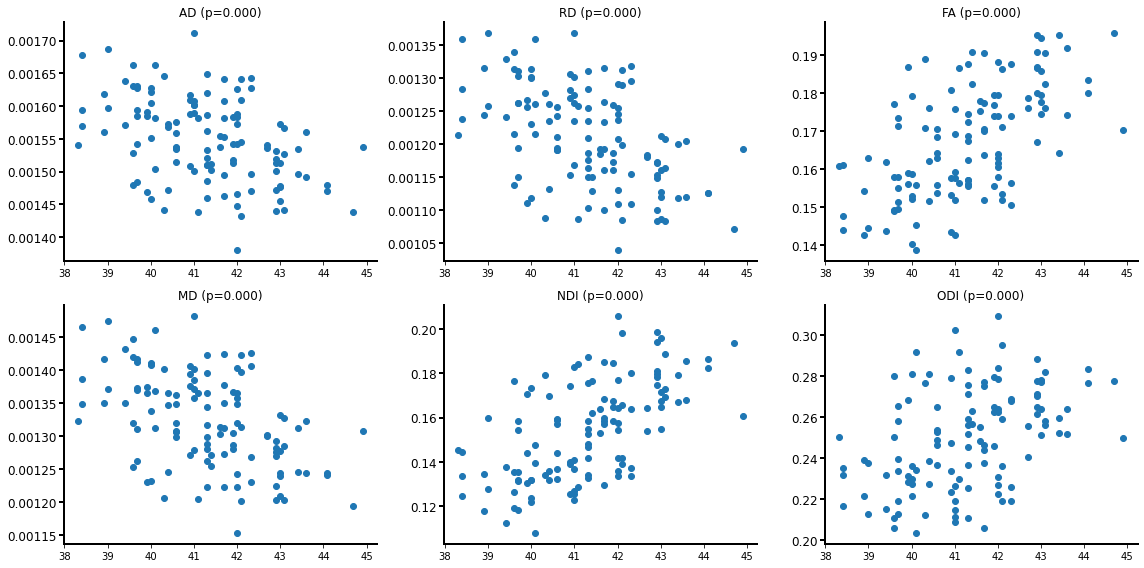

In [7]:
fig, axs = plt.subplots(2,3, figsize=(16,8))
axs = axs.ravel()
for i, metric in enumerate(['AD', 'RD', 'FA', 'MD', 'NDI', 'ODI']):
    
    axs[i].scatter(df['scan_age'], df['meanWM_'+metric])
    test = pg.linear_regression(df['scan_age'], df['meanWM_'+metric])
    
    p = np.float32(test['pval'][1])
    axs[i].set_title(metric+ ' (p={:.3f})'.format(p))

    
fig.patch.set_facecolor('white')

#axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), 
#           ncol = 4, fontsize=18, frameon=False, markerscale=0.6)   

for i in range(6):
    for j in range(3):
        # Hide the right and top spines
        axs[i].spines['right'].set_visible(False)
        axs[i].spines['top'].set_visible(False)
        for axis in ['bottom','left']:
            axs[i].spines[axis].set_linewidth(2)
        
        axs[i].tick_params(axis='y', labelsize=12)    
        plt.setp(axs[i].yaxis.get_ticklines(), 'markeredgewidth', 2)
        plt.setp(axs[i].yaxis.get_ticklines(), 'markersize', 5)

        
plt.tight_layout()
plt.show()
    

In [168]:
np.float32(test['pval'][1])

1.2870644e-11

In [150]:
sets = [['AD','RD'], ['FA', 'MD'], ['NDI', 'ODI']]
set_names = ['set1', 'set2', 'set3']

#sets = [['AD','RD','FA', 'MD','NDI', 'ODI']]
#set_names = ['set1']

In [151]:
### 1. scale the features first 

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_df = df.copy()


for metric in ['AD', 'RD', 'FA', 'MD', 'NDI', 'ODI']:
    metric_subset = [tract + '_' + metric for tract in pair_names]
    for col in metric_subset:
        scaled_df[col] = scaler.fit_transform(df[[col]])

## scale mean WM as well 
for metric in ['AD', 'RD', 'FA', 'MD', 'NDI', 'ODI']:
    
    scaled_df['meanWM_'+metric] = scaler.fit_transform(df[['meanWM_'+metric]])

        
### 2. compute mahalanobis 
mah_results = pd.DataFrame()

for tract in pair_names:
    for subset, name in zip(sets, set_names):
        features = np.array([tract+'_'+metric for metric in subset])
    
        control_ar = scaled_df[scaled_df.subject_id.isin(control_ids)][features].values
        ## normalize by mean 
        mean_control = np.mean(control_ar, axis=0)
        #range_control = np.ptp(control_ar, axis=0)
        #std_control = np.std(control_ar, axis=0)
        control_ar = (control_ar / mean_control) #/ range_control
    
        ## get inverse covariance matrix for the control group 
        corr = np.cov(control_ar.T)
        corrI = np.linalg.inv(corr)
        
        distances = []
    
        for i, preterm in enumerate(preterm_ids):
            subj_vect = scaled_df[scaled_df.subject_id == preterm][features].values[0]
            subj_vect = (subj_vect / mean_control)# / range_control
            cont_vect = np.mean(control_ar, axis=0) 
            #cont_vect = np.ones_like(subj_vect)
        
            #print(subj_vect)
            mh = mahalanobis(u = subj_vect, v = cont_vect, VI=corrI)
        
            #mh = np.sqrt(np.dot(np.dot((subj_vect - cont_vect).T,corrI), (subj_vect - cont_vect)))
            #print(mh)
        
            mah_results.loc[i,'subject_id'] = preterm
            mah_results.loc[i, tract+'_mh_'+name] = mh
            
            
##### WHAT TO DO WITH THE RESIDUAL WM??? 
# can I compute mahalanobis from mean WM metrics (should this be scaled also) & then compute residual etc? 
## scaled WM's previously 

for subset, name in zip(sets, set_names):
    features = np.array(['meanWM_'+metric for metric in subset])
    control_ar = scaled_df[scaled_df.subject_id.isin(control_ids)][features].values
    ## normalize by mean 
    mean_control = np.mean(control_ar, axis=0)
    #range_control = np.ptp(control_ar, axis=0)
    #std_control = np.std(control_ar, axis=0)
    control_ar = (control_ar / mean_control) #/ range_control
    
    ## get inverse covariance matrix for the control group 
    corr = np.cov(control_ar.T)
    corrI = np.linalg.inv(corr)
    
    for i, preterm in enumerate(preterm_ids):
        subj_vect = scaled_df[scaled_df.subject_id == preterm][features].values[0]
        subj_vect = (subj_vect / mean_control)# / range_control
        cont_vect = np.mean(control_ar, axis=0) 
        #cont_vect = np.ones_like(subj_vect)
        
        #print(subj_vect)
        mh = mahalanobis(u = subj_vect, v = cont_vect, VI=corrI)
        
        #mh = np.sqrt(np.dot(np.dot((subj_vect - cont_vect).T,corrI), (subj_vect - cont_vect)))
        #print(mh)
        
        mah_results.loc[i,'subject_id'] = preterm
        mah_results.loc[i, 'meanWM_mh_'+name] = mh

### get WM residuals 


merged_mh = pd.merge(mah_results, df, how="inner", on=["subject_id"])
mh_cols = [col for col in merged_mh.columns if '_mh_' in col]
mh_cols = [col for col in mh_cols if 'meanWM' not in col]


for metric in ['set1', 'set2', 'set3']:
#for metric in ['set1']:

    merged_mh['residual_meanWM_mh_'+metric] = get_residuals(global_WM = np.float32(merged_mh['meanWM_mh_' + metric].values), 
                                           scan_age = np.float32(merged_mh['scan_age'].values))

### 3. adjust mahalanobis for confounders  


after_correction = pd.DataFrame()
after_correction['birth_age'] = merged_mh['birth_age']

for col in mh_cols:
    
    comparison = col.split('_')[-1]
    
    
    correction = pg.linear_regression(X =  merged_mh[[ 'scan_age', 'Sex', 'residual_meanWM_mh_'+comparison, 'PregnancySize','FetalGrowthRestriction', 'ParenteralNutrition' ]], y = merged_mh[col])
    res = correction.residuals_
        
    after_correction[col] = res

In [152]:
### COMPUTE THE LINEAR REGRESSION WITH AGE 
results = pd.DataFrame()

pairs = [col.split('_')[0] for col in after_correction.columns[1:]]
pairs = np.unique(np.array(pairs))

for col in pairs:
    
    for i, subset in enumerate(['set1', 'set2', 'set3']):
    #for i, subset in enumerate(['set1']):
        
        test= pg.linear_regression(X = after_correction['birth_age'], y = after_correction[col+'_mh_'+subset])

        results.loc[i, 'set'] = subset
        results.loc[i, col] = np.float64(test['pval'][1])
    #results_T.loc[i, new_col+'_T'] = np.round(np.float64(test['T'][1]),2)
    #results_T.loc[i, new_col+'_slope'] = np.float64(test['coef'][1])

        
results[results.columns[1:]] = results[results.columns[1:]].astype(np.float64)

pre_p = results[results.columns[1:]].values.ravel()
reject, pvals_corr = pg.multicomp(pre_p, method='fdr_bh')
pvals_corr = pvals_corr.reshape(np.shape(results[results.columns[1:]].values))

results[results.columns[1:]] = pvals_corr

In [153]:
results

,set,M1-Brainstem,M1-Caud,M1-Lenti,M1-Thalfus,M1L-M1R,Paracentral-Brainstem,Paracentral-Caud,Paracentral-Lenti,Paracentral-Thalfus,S1-Brainstem,S1-Caud,S1-Lenti,S1-M1,S1-Thalfus,S1L-S1R
0,set1,0.985138,0.985138,0.998840,0.985138,0.985138,0.985138,0.985138,0.985138,0.985138,0.985138,0.985138,0.985138,0.985138,0.985138,0.985138
1,set2,0.985138,0.985138,0.985138,0.985138,0.985138,0.985138,0.985138,0.985138,0.985138,0.985138,0.985138,0.985138,0.985138,0.985138,0.985138
2,set3,0.985138,0.985138,0.985138,0.985138,0.985138,0.985138,0.985138,0.985138,0.985138,0.985138,0.985138,0.985138,0.985138,0.985138,0.985138


In [154]:
colors = {'Brainstem' : 'forestgreen',
          'Caud' : 'darkmagenta', 
          'Lenti': 'blue', 
         'Thalfus': 'gray', 
          'M1R' : 'magenta', 
          'S1R' : 'magenta',
          'M1': 'teal' }

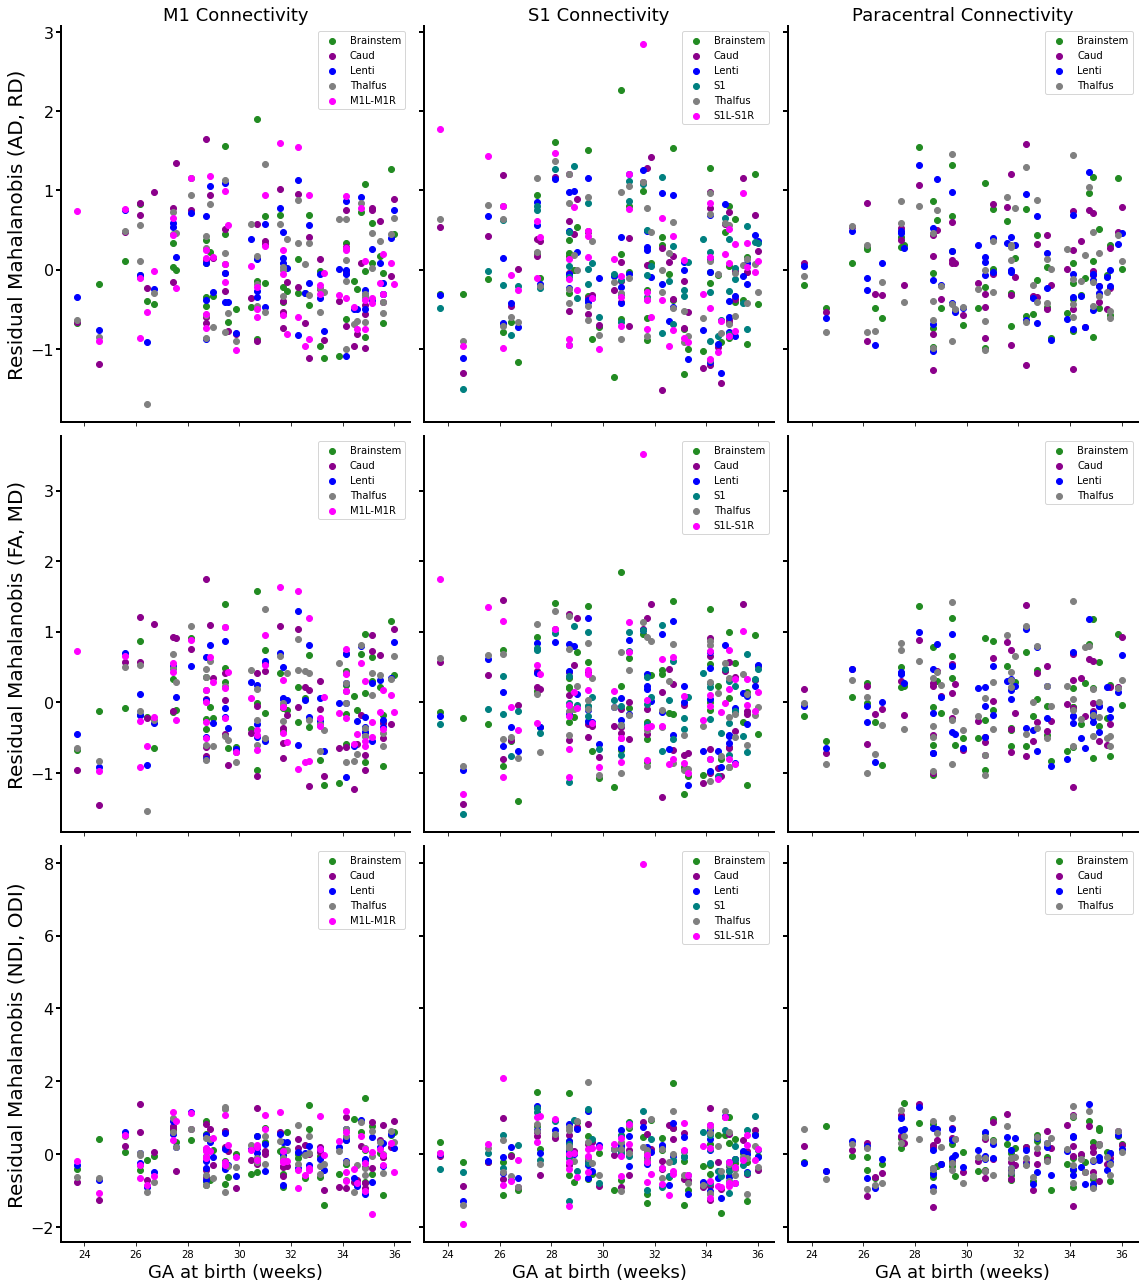

In [155]:
pairs = [col.split('_')[0] for col in after_correction.columns[1:]]
pairs = np.unique(np.array(pairs))

fig, axs = plt.subplots(3,3, figsize=(16,18), sharex=True, sharey='row')

for i, subset in enumerate(['set1', 'set2', 'set3']):
    for pair in pairs: 
        #print(name)
        if  pair in ['M1-Brainstem', 'M1-Caud', 'M1-Lenti', 'M1-Thalfus', 'M1L-M1R', 'S1-M1']:
            ax_idx = 0
        if pair in ['S1-Brainstem', 'S1-Caud', 'S1-Lenti', 'S1-Thalfus', 'S1L-S1R', 'S1-M1']: 
            ax_idx = 1
        elif pair in ['Paracentral-Brainstem', 'Paracentral-Caud', 'Paracentral-Lenti', 'Paracentral-Thalfus']: 
            ax_idx = 2
            
            
        if pair == 'S1-M1':
            label = pair.split('-')[0] 
            
        elif pair in ['S1L-S1R', 'M1L-M1R']:
            label = pair 
        else: 
            label = pair.split('-')[1] 
            
            
            
        axs[i,ax_idx].scatter( after_correction['birth_age'].values, after_correction[pair +'_mh_'+subset].values, 
                             c = colors[pair.split('-')[1]], label=label)
        axs[i,ax_idx].legend(loc='upper right')

for i in range(3):
    axs[2,i].set_xlabel('GA at birth (weeks)', fontsize=18)
    
axs[0,0].set_title('M1 Connectivity', fontsize=18)
axs[0,1].set_title('S1 Connectivity', fontsize=18)
axs[0,2].set_title('Paracentral Connectivity', fontsize=18)

axs[0,0].set_ylabel('Residual Mahalanobis (AD, RD)', fontsize=20)
axs[1,0].set_ylabel('Residual Mahalanobis (FA, MD)', fontsize=20)
axs[2,0].set_ylabel('Residual Mahalanobis (NDI, ODI)', fontsize=20)

fig.patch.set_facecolor('white')

#axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), 
#           ncol = 4, fontsize=18, frameon=False, markerscale=0.6)   

for i in range(3):
    for j in range(3):
        # Hide the right and top spines
        axs[i,j].spines['right'].set_visible(False)
        axs[i,j].spines['top'].set_visible(False)
        for axis in ['bottom','left']:
            axs[i,j].spines[axis].set_linewidth(2)
        
        axs[i,j].tick_params(axis='y', labelsize=16)    
        plt.setp(axs[i,j].yaxis.get_ticklines(), 'markeredgewidth', 2)
        plt.setp(axs[i,j].yaxis.get_ticklines(), 'markersize', 5)

        
plt.tight_layout()
plt.show()

### bundle distances 

In [135]:
from itertools import combinations

subset='set1'
pvals = []
for combination in list(combinations(pairs, 2)):
    test = pg.ttest(after_correction[combination[0]+'_mh_'+subset].values,
                    after_correction[combination[1]+'_mh_'+subset].values, paired=True)
    
    p = "{:.9f}".format(test['p-val'].values[0])
    pvals.append(p)
    
    
reject, pvals_corr = pg.multicomp(np.array(pvals).astype(np.float64), method='fdr_bh')

ordering = pd.DataFrame(columns=['region1', 'region2', 'corrected_p'])
i=0
for val, combination in zip(pvals_corr, list(combinations(pairs, 2))):
    #print(combination,  "{:.5f}".format(val))
    ordering.loc[i, 'region1'] = combination[0]
    ordering.loc[i, 'region2'] = combination[1]
    ordering.loc[i, 'corrected_p'] = "{:.5f}".format(val)
    i = i+1
    
ordering['corrected_p'] = ordering['corrected_p'].astype(np.float64)

In [136]:
regions = [reg for reg in ordering.region1.values]
for reg in ordering.region2.values:
    regions.append(reg)
    
edges = []
weights = []

for i, row in ordering.iterrows():
    if row.corrected_p > 0.05:
        edges.append((row.region1, row.region2))
        weights.append(row.corrected_p)

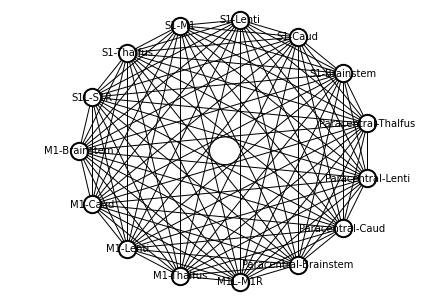

In [137]:
import networkx as nx 
G = nx.Graph()
G.add_nodes_from(regions)
G.add_edges_from(edges, weights=weights)

options = {
    'font_size': 10,
    #'node_size' : 5000,
    'node_color': 'white',
    'edgecolors' : 'black',
    'linewidths': 2,
    'width': list(weights)
}

pos = nx.shell_layout(G)
nx.draw(G, pos, with_labels= True, **options)

x_values, y_values = zip(*pos.values())
x_max, x_min = max(x_values), min(x_values)
x_margin = (x_max - x_min) * 0.25
plt.xlim(x_min - x_margin, x_max + x_margin)
plt.show()

In [138]:
for h in nx.connected_components(G):
    print(h)

{'S1-Brainstem', 'S1-Lenti', 'S1-Thalfus', 'Paracentral-Brainstem', 'M1-Thalfus', 'Paracentral-Thalfus', 'M1-Lenti', 'M1-Brainstem', 'M1-Caud', 'Paracentral-Caud', 'S1L-S1R', 'S1-M1', 'Paracentral-Lenti', 'S1-Caud', 'M1L-M1R'}
